In [1]:
%matplotlib inline

# 鑑黃大師

![md_images](../Images/porndetector.jpg?raw=true)

![md_images](../Images/pornclass.jpg?raw=true)

In [2]:
# im = cv2.imread(imgpath)
# rr = random.randint(0, 10)
# if rr % 3 == 0:
#     im = cv2.resize(im, (64, 64), interpolation=cv2.INTER_AREA)
# elif rr % 3 == 1:
#     scale = 64 / max(im.shape[:2])
#     im_org = cv2.resize(im, (int(im.shape[1] * scale), int(im.shape[0] * scale)), interpolation=cv2.INTER_AREA)
#     im = np.ones((64, 64, 3), dtype=np.float32) * 255
#     im[:im_org.shape[0], :im_org.shape[1], :] = im_org
# elif rr % 3 == 2:
#     scale = 64 / min(im.shape[:2])
#     im_org = cv2.resize(im, (int(im.shape[1] * scale), int(im.shape[0] * scale)), interpolation=cv2.INTER_AREA)
#     offset_x = 0
#     if im_org.shape[1] > 64:
#         offset_x = random.choice(range(0, im_org.shape[1] - 64))
#     offset_y = 0
#     if im_org.shape[0] > 64:
#         offset_y = random.choice(range(0, im_org.shape[0] - 64))
#     im = im_org[offset_y:offset_y + 64 , offset_x:offset_x + 64 , :]

In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
import pickle
import PIL
from PIL import Image


import tqdm

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from  torchvision.datasets import *


# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


10001
5746


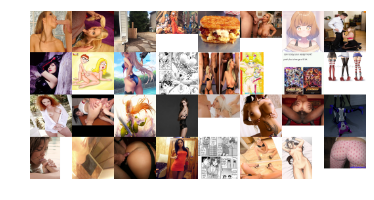

In [4]:
f1 = open('../Data/train_porn_detector64_small.pkl', 'rb')
trainData=pickle.load(f1)  
f2 = open('../Data/test_porn_detector64_small.pkl', 'rb')
testData=pickle.load(f2)  
print(len(trainData[0]))
print(len(testData[0]))

idx=0
idxs=np.arange(len(trainData[0]))
np.random.shuffle(idxs)

sample_img=np.zeros((3,64*4,64*8),dtype=np.float32)
numrows, numcols = 4, 8
height = 64
width = 64
for row in range(numrows):
    for col in range(numcols):
        y0 = row * height
        y1 = y0 + height
        x0 = col * width
        x1 = x0 + width
      
        sample_img[:,y0:y1, x0:x1]=trainData[0][idxs[idx]][::-1][:,:,:]
        idx+=1

sample_img=np.transpose(sample_img.astype(np.uint8),[1,2,0])
img=Image.fromarray(sample_img)
plt.axis('off')
plt.imshow(img)

In [5]:


def get_next_minibatch(minibatch_size):
    global idx,idxs
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        features.append(trainData[0][idxs[idx]]/255.0)
        labels.append(int(trainData[1][idxs[idx]]))
        idx+=1
        if idx>=len(idxs):
            idx=0
            idxs=np.arange(len(trainData[0]))
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.int64)

idx1=0
idxs1=np.arange(len(testData[0]))
np.random.shuffle(idxs1)
def get_next_test_minibatch(minibatch_size):
    global idx1,idxs1
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        features.append(testData[0][idxs1[idx1]]/255.0)
        labels.append(int(testData[1][idxs1[idx1]]))
        idx1+=1
        if idx1>=len(idxs1)-1:
            idx1=0
            np.random.shuffle(idxs1)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.int64)

features_x,labels_y=get_next_minibatch(8)
print(features_x.shape)
print(labels_y.shape)

(8, 3, 64, 64)
(8,)


![md_images](../Images/vgg16.png?raw=true)

![md_images](../Images/global_average_pooling.png?raw=true)

In [6]:
class vgg16_bn(nn.Module):
    def __init__(self,num_classes=5):
        super(vgg16_bn, self).__init__()
        self.cfg=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        self.basenet=None
        self.conv1x1=nn.Conv2d(512, 5, kernel_size=1, stride=1, bias=True)
        self.fc=nn.Linear(num_classes, num_classes)
        self.layers =[] 
        self.make_layers(self.cfg,True)

    def forward(self, x):
        x= self.basenet(x)
        x= self.conv1x1(x)
        x = torch.mean(torch.mean(x, -1, False), -1, False)
        x= self.fc(x)
        return x

    def make_layers(self,cfg, batch_norm=True):
        self.layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                self.layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    self.layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    self.layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        
        self.basenet = nn.Sequential(*self.layers)
      
        




In [7]:
num_epochs=3
minibatch_size=16

vgg16=vgg16_bn()
model=vgg16.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion= nn.CrossEntropyLoss()

losses=[]
metrics=[]
print('epoch start')
for epoch in range(num_epochs):
    mbs = 0
    while mbs <10000//minibatch_size:
        raw_features,raw_labels=get_next_minibatch(minibatch_size)
        input, target = torch.from_numpy(raw_features), torch.from_numpy(raw_labels)
        input, target = Variable(input).to(device), Variable(target).to(device)
        output = model(input)
        #print(output.shape)
        loss=criterion(output,target)
        #print(np.argmax(output.cpu().detach().numpy(),1).astype(np.int64).shape)
        #print(target.cpu().detach().numpy().astype(np.int64).shape)
        accu = np.mean(np.equal(np.argmax(output.cpu().detach().numpy(),1).astype(np.int64), target.cpu().detach().numpy().astype(np.int64)))
        losses.append(loss.item())
        metrics.append(accu)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if mbs % 50 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, num_epochs),
                  "Step: {} ".format(mbs),
                  "Loss: {:.4f}...".format(np.asarray(losses).mean()),
                  "Accuracy:{:.3%}...".format(np.asarray(metrics).mean()),)
            losses=[]
            metrics=[]

        mbs += 1




epoch start
Epoch: 1/3  Step: 0  Loss: 1.6843... Accuracy:12.500%...
Epoch: 1/3  Step: 50  Loss: 1.2886... Accuracy:48.125%...
Epoch: 1/3  Step: 100  Loss: 1.1289... Accuracy:58.125%...
Epoch: 1/3  Step: 150  Loss: 1.0774... Accuracy:58.750%...
Epoch: 1/3  Step: 200  Loss: 1.1354... Accuracy:58.000%...
Epoch: 1/3  Step: 250  Loss: 1.0158... Accuracy:62.125%...
Epoch: 1/3  Step: 300  Loss: 1.0986... Accuracy:57.875%...
Epoch: 1/3  Step: 350  Loss: 1.0187... Accuracy:62.500%...
Epoch: 1/3  Step: 400  Loss: 1.0558... Accuracy:60.500%...
Epoch: 1/3  Step: 450  Loss: 1.0096... Accuracy:60.500%...
Epoch: 1/3  Step: 500  Loss: 0.9869... Accuracy:63.000%...
Epoch: 1/3  Step: 550  Loss: 1.0395... Accuracy:60.125%...
Epoch: 1/3  Step: 600  Loss: 0.9950... Accuracy:63.500%...
Epoch: 2/3  Step: 0  Loss: 1.0252... Accuracy:61.750%...
Epoch: 2/3  Step: 50  Loss: 0.9582... Accuracy:63.250%...
Epoch: 2/3  Step: 100  Loss: 0.9337... Accuracy:66.500%...
Epoch: 2/3  Step: 150  Loss: 0.9590... Accuracy:64

In [14]:
test_features,test_labels = get_next_test_minibatch(minibatch_size*2)

input, target = torch.from_numpy(test_features), torch.from_numpy(test_labels)
input, target = Variable(input).to(device), Variable(target).to(device)
output = model(input)
loss=criterion(output,target)
accu = np.mean(np.equal(np.argmax(output.cpu().detach().numpy(),1).astype(np.int64), target.cpu().detach().numpy().astype(np.int64)))


print(accu.shape)
print('Loss:{:.4f}'.format(np.mean(loss.item())))
print('Accuracy:{:.3%}'.format(accu))


()
Loss:1.0399
Accuracy:68.750%


## 數據增強 Data Augmentation 

In [9]:
coverage = 220 
rotation_range = 150
zoom_range = 0.8
shift_range = 0.3
random_flip = 0.5

#隨機進行旋轉 縮放 位移 反轉等圖像操作
def random_transform(image, rotation_range=rotation_range, zoom_range=zoom_range, shift_range=shift_range,
                     random_flip=random_flip):
    #chw->hwc
    image = image.transpose([1, 2, 0])
    h, w = image.shape[0:2]
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    tx = np.random.uniform(-shift_range, shift_range) * w
    ty = np.random.uniform(-shift_range, shift_range) * h
    mat = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    mat[:, 2] += (tx, ty)
    new_image = cv2.warpAffine(image, mat, (w, h))  # , borderMode=cv2.BORDER_REPLICATE
 
    if np.random.random() < random_flip:
        new_image = new_image[:, ::-1]
    new_image = new_image.transpose([2, 0, 1])

    return new_image

#隨機加入標準常態分配的噪聲
def add_noise(image):
    noise=np.random.standard_normal(image.shape)*np.random.choice(np.arange(-25,25))
    image=np.clip(image+noise,0,255)
    return image

#調整明暗
def adjust_gamma(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    image=cv2.LUT(image.astype(np.uint8), table)
    image = image.transpose([2, 0, 1])
    return image




In [10]:
def get_next_minibatch(minibatch_size):
    global idx,idxs,adjust_gamma,add_noise,random_transform
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        #加入數據增強
        img=trainData[0][idxs[idx]]
        img=random_transform(img)
        img=add_noise(img)
        #隨機選擇亮度gamma為0.6~1.5之間數字
        gamma=np.random.choice(np.arange(0.6, 1.5, 0.05))
        img=adjust_gamma(img,gamma)
        
        features.append(img/255.0)
        labels.append(int(trainData[1][idxs[idx]]))
        idx+=1
        if idx>len(idxs)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.int64)


def save_weights(model, epoch, loss, err):
    weights_fname = 'weights-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = "Models/{0}".format(weights_fname)
    torch.save({
            'startEpoch': epoch,
            'loss':loss,
            'error': err,
            'state_dict': model.state_dict()
        }, weights_fpath)
   


vgg16=vgg16_bn()
model=vgg16.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion= nn.CrossEntropyLoss()

losses=[]
metrics=[]
print('epoch start')
for epoch in range(num_epochs):
    mbs = 0
    while mbs <10000//minibatch_size:
        raw_features,raw_labels=get_next_minibatch(minibatch_size)
        input, target = torch.from_numpy(raw_features), torch.from_numpy(raw_labels)
        input, target = Variable(input).to(device), Variable(target).to(device)
        output = model(input)
        #print(output.shape)
        loss=criterion(output,target)
        #print(np.argmax(output.cpu().detach().numpy(),1).astype(np.int64).shape)
        #print(target.cpu().detach().numpy().astype(np.int64).shape)
        accu = np.mean(np.equal(np.argmax(output.cpu().detach().numpy(),1).astype(np.int64), target.cpu().detach().numpy().astype(np.int64)))
        losses.append(loss.item())
        metrics.append(accu)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if mbs % 50 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, num_epochs),
                  "Step: {} ".format(mbs),
                  "Loss: {:.4f}...".format(np.asarray(losses).mean()),
                  "Accuracy:{:.3%}...".format(np.asarray(metrics).mean()),)
            losses=[]
            metrics=[]

        mbs += 1
    save_weights(model, epoch, loss, accu)



epoch start
Epoch: 1/3  Step: 0  Loss: 1.7214... Accuracy:12.500%...
Epoch: 1/3  Step: 50  Loss: 1.4297... Accuracy:43.375%...
Epoch: 1/3  Step: 100  Loss: 1.3256... Accuracy:50.250%...
Epoch: 1/3  Step: 150  Loss: 1.2369... Accuracy:53.125%...
Epoch: 1/3  Step: 200  Loss: 1.1926... Accuracy:55.625%...
Epoch: 1/3  Step: 250  Loss: 1.2530... Accuracy:53.250%...
Epoch: 1/3  Step: 300  Loss: 1.2561... Accuracy:52.750%...
Epoch: 1/3  Step: 350  Loss: 1.2535... Accuracy:54.000%...
Epoch: 1/3  Step: 400  Loss: 1.2152... Accuracy:55.000%...
Epoch: 1/3  Step: 450  Loss: 1.1648... Accuracy:54.875%...
Epoch: 1/3  Step: 500  Loss: 1.1612... Accuracy:55.125%...
Epoch: 1/3  Step: 550  Loss: 1.2076... Accuracy:54.125%...
Epoch: 1/3  Step: 600  Loss: 1.1241... Accuracy:58.375%...
Epoch: 2/3  Step: 0  Loss: 1.1661... Accuracy:55.500%...
Epoch: 2/3  Step: 50  Loss: 1.1912... Accuracy:56.125%...
Epoch: 2/3  Step: 100  Loss: 1.0850... Accuracy:59.125%...
Epoch: 2/3  Step: 150  Loss: 1.2106... Accuracy:53

In [20]:
test_features,test_labels = get_next_test_minibatch(minibatch_size*2)

input, target = torch.from_numpy(test_features), torch.from_numpy(test_labels)
input, target = Variable(input).to(device), Variable(target).to(device)
output = model(input)
loss=criterion(output,target)
accu = np.mean(np.equal(np.argmax(output.cpu().detach().numpy(),1).astype(np.int64), target.cpu().detach().numpy().astype(np.int64)))

print('Loss:{:.4f}'.format(np.mean(loss.item())))
print('Accuracy:{:.3%}'.format(accu))


Loss:0.8986
Accuracy:62.500%


![md_images](../Images/venus.jpg?raw=true)

In [22]:
imarr=cv2.imread('../Images/venus.jpg')
imarr=cv2.resize(imarr,(64,64), interpolation=cv2.INTER_AREA)
imarr=np.ascontiguousarray(np.transpose(imarr,[2,0,1]))
imarr=np.expand_dims(imarr/255.0,0)
result=output.data.cpu().max(1)[1]
print(result)

#0 繪畫,1 變態,2 中性,3 色情,4 性感
#預測結果是3屬於色情片等級

tensor([3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1,
        1, 3, 3, 3, 3, 3, 0, 3])


![md_images](../Images/JutisfyMyLove.jpg?raw=true)

In [23]:
imarr=cv2.imread('../Images/JutisfyMyLove.jpg')
imarr=cv2.resize(imarr,(64,64), interpolation=cv2.INTER_AREA)
imarr=np.ascontiguousarray(np.transpose(imarr,[2,0,1]))
imarr=np.expand_dims(imarr/255.0,0)
result=output.data.cpu().max(1)[1]
print(result)

#0 繪畫,1 變態,2 中性,3 色情,4 性感
#預測結果是3屬於色情片等級

tensor([3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1,
        1, 3, 3, 3, 3, 3, 0, 3])
